# Financial Credit Risk Model
## Michael Tondu

This notebook explores historical customer credit data from a bank in Spain in order to create a Supervised Learning model which outputs the probability of a given future customer defaulting on his/her loan.

The process consists of EDA, visualization, Feature engineering, running ML algorithms on the transformed data and then using grid search to find the optimal parameters.

##### This project achieved the best roc auc score in the financial analytics Master's class at IE University with 50 people.

In [2]:
# Loading necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import sklearn as sk

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from __future__ import print_function
%matplotlib inline  

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [3]:
#Loading the Data 
training_data = pd.read_csv('challengeTrain.csv').drop('customerID', axis=1)
test_data = pd.read_csv('challengeTest.csv')
test_ids = test_data.customerID


### Data Exploration & Feature Engineering

In [4]:
# Shape of the data
training_data.shape
test_data.shape

(522939, 17)

(174313, 17)

In [7]:
# statistical properties
training_data[training_data.columns[0:]].describe()
training_data.info()
training_data[training_data.columns[0:]].median()


age  externalScore       indSimin       indXlist  \
count  500238.000000  514626.000000  522939.000000  522939.000000   
mean       39.095415     591.346281       0.099002       0.053599   
std        13.952843     261.921840       0.298665       0.225225   
min        18.000000       1.000000       0.000000       0.000000   
25%        28.000000     458.000000       0.000000       0.000000   
50%        37.000000     649.000000       0.000000       0.000000   
75%        48.000000     791.000000       0.000000       0.000000   
max       111.000000     995.000000       1.000000       1.000000   

       indCreditBureau    indInternet     indBadDebt       numLoans  \
count    522939.000000  522939.000000  522939.000000  267338.000000   
mean          0.042443       0.775509       0.290831       1.203432   
std           0.201597       0.417247       0.454146       1.243055   
min           0.000000       0.000000       0.000000       0.000000   
25%           0.000000       1.000000       0.000000       0.000000   
50%           0.000000       1.000000       0.000000       1.000000   
75%           0.000000       1.000000       1.000000       2.000000   
max           1.000000       1.000000       1.000000      14.000000   

        numMortgages  indBadLocation  sumExternalDefault         target  
count  267338.000000   522939.000000        5.202600e+05  522939.000000  
mean        0.048665        0.168915        4.836326e+02       0.340265  
std         0.220015        0.374677        1.084238e+04       0.473799  
min         0.000000        0.000000        0.000000e+00       0.000000  
25%         0.000000        0.000000        0.000000e+00       0.000000  
50%         0.000000        0.000000        0.000000e+00       0.000000  
75%         0.000000        0.000000        3.409000e+01       1.000000  
max         3.000000        1.000000        6.021214e+06       1.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522939 entries, 0 to 522938
Data columns (total 17 columns):
sex                   522939 non-null object
status                522939 non-null object
age                   500238 non-null float64
externalScore         514626 non-null float64
indSimin              522939 non-null int64
indXlist              522939 non-null int64
indCreditBureau       522939 non-null int64
indInternet           522939 non-null int64
indBadDebt            522939 non-null int64
salary                522939 non-null object
numLoans              267338 non-null float64
numMortgages          267338 non-null float64
channel               522939 non-null object
indBadLocation        522939 non-null int64
previous              522939 non-null object
sumExternalDefault    520260 non-null float64
target                522939 non-null int64
dtypes: float64(5), int64(7), object(5)
memory usage: 67.8+ MB


age                    37.0
externalScore         649.0
indSimin                0.0
indXlist                0.0
indCreditBureau         0.0
indInternet             1.0
indBadDebt              0.0
numLoans                1.0
numMortgages            0.0
indBadLocation          0.0
sumExternalDefault      0.0
target                  0.0
dtype: float64

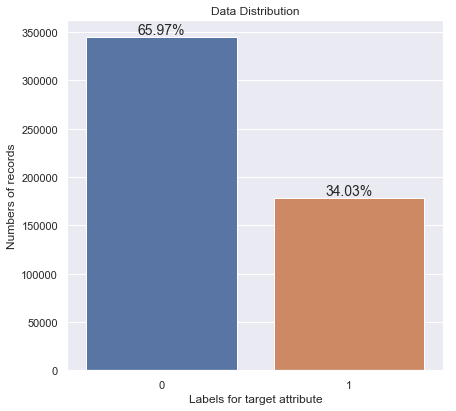

In [12]:
# Distribution of target variable
total_len = len(training_data['target'])
percentage_labels = (training_data['target'].value_counts()/total_len)*100
percentage_labels

# Graphical representation of the target label 

fig = plt.figure(figsize=(6,6))
style.use('fivethirtyeight')
sns.set()

sns.countplot(training_data.target).set_title('Data Distribution')
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100*(height/total_len)),
            fontsize=14, ha='center', va='bottom')
sns.set(font_scale=1.5)
ax.set_xlabel("Labels for target attribute")
ax.set_ylabel("Numbers of records")
plt.show();

Binary target variable, therefore this the model will be a binary classificator.

AttributeError: module 'matplotlib.pyplot' has no attribute 'to'

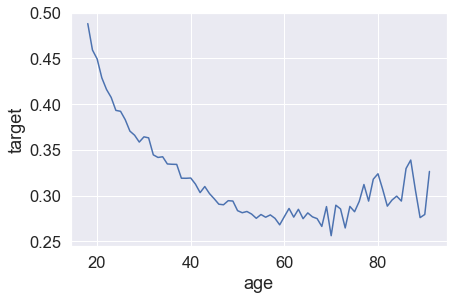

In [23]:
# Grouping data by age
data=training_data.groupby('age').mean().dropna()
sns.lineplot(x=data.index, y=data.target)
plt.title('% Defaults by age')
plt.show();


In [26]:
# Grouping data by salary
training_data.groupby('salary').mean()

age  externalScore  indSimin  indXlist  indCreditBureau  \
salary                                                                       
<650         33.856011     573.757064  0.081047  0.059931         0.015250   
>8000        43.160221     781.678479  0.126747  0.004225         0.056549   
None         29.345029     541.833333  0.044905  0.073978         0.000288   
Unknown            NaN            NaN  0.284546  0.002862         0.000000   
[1000,1300)  38.523673     559.878319  0.087928  0.062231         0.041336   
[1300,1500)  41.608091     573.335679  0.107674  0.053321         0.064327   
[1500,2000)  41.660106     631.695990  0.114570  0.039296         0.054317   
[2000,3000)  42.106848     679.647437  0.132163  0.030220         0.048765   
[3000,5000)  42.568322     724.417526  0.148561  0.022509         0.051653   
[5000,8000)  42.609275     756.261111  0.135518  0.013746         0.056651   
[650,1000)   34.094475     586.500179  0.082448  0.061038         0.016072   

             indInternet  indBadDebt  numLoans  numMortgages  indBadLocation  \
salary                                                                         
<650            0.740743    0.425329  0.900640      0.000337        0.312608   
>8000           0.853754    0.233994  2.248771      0.624058        0.082223   
None            0.819516    0.006333  0.000000      0.000000        0.165227   
Unknown         0.880213    0.000000       NaN           NaN        0.000000   
[1000,1300)     0.767451    0.287007  0.865186      0.002104        0.174068   
[1300,1500)     0.781523    0.322701  1.106329      0.008398        0.118359   
[1500,2000)     0.789000    0.291626  1.475264      0.024392        0.124723   
[2000,3000)     0.798569    0.270255  1.645466      0.094115        0.127697   
[3000,5000)     0.816076    0.255538  1.698552      0.211718        0.113197   
[5000,8000)     0.821300    0.241877  1.860439      0.396611        0.097334   
[650,1000)      0.758703    0.293375  0.927354      0.000489        0.263230   

             sumExternalDefault    target  
salary                                     
<650                 228.192702  0.586759  
>8000                491.751644  0.093598  
None                   3.111665  0.453656  
Unknown                     NaN  0.224039  
[1000,1300)          424.284999  0.369607  
[1300,1500)          732.596397  0.288813  
[1500,2000)          663.151947  0.239559  
[2000,3000)          683.386474  0.195319  
[3000,5000)          742.242136  0.157979  
[5000,8000)          603.138456  0.125243  
[650,1000)           193.606605  0.475295

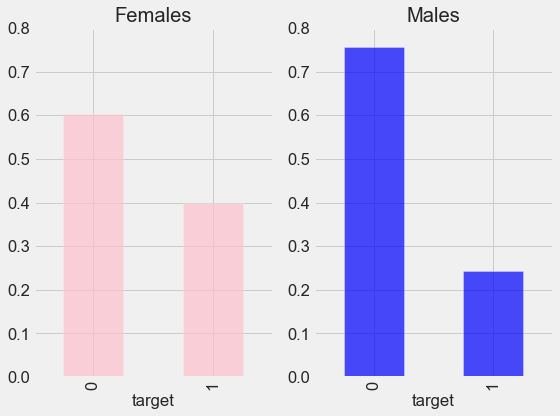

In [28]:
# Grouping data by sex

male = training_data[training_data.sex=='Male'].groupby('target').size()/training_data[training_data.sex=='Male'].shape[0]
female = training_data[training_data.sex=='Female'].groupby('target').size()/training_data[training_data.sex=='Female'].shape[0]

# Plotting target distribution by sex 
my_colors = 'bmgrkyc'

fig = plt.figure(figsize=(8,6))
style.use('fivethirtyeight')
plt.subplot(1,2,1)
female.plot(kind='bar', color='pink', title='Females', alpha=0.7, ylim=[0.0, 0.8])
plt.subplot(1,2,2)
male.plot(kind='bar', color='blue', title='Males', alpha=0.7, ylim=[0.0, 0.8])
plt.tight_layout();

Women tend to default on their loans at a higher rate than men.

### Imputing Null Values

In [22]:
#looking for nulls
training_data.isnull().sum()

sex                        0
status                     0
age                    22701
externalScore           8313
indSimin                   0
indXlist                   0
indCreditBureau            0
indInternet                0
indBadDebt                 0
salary                     0
numLoans              255601
numMortgages          255601
channel                    0
indBadLocation             0
previous                   0
sumExternalDefault      2679
target                     0
dtype: int64

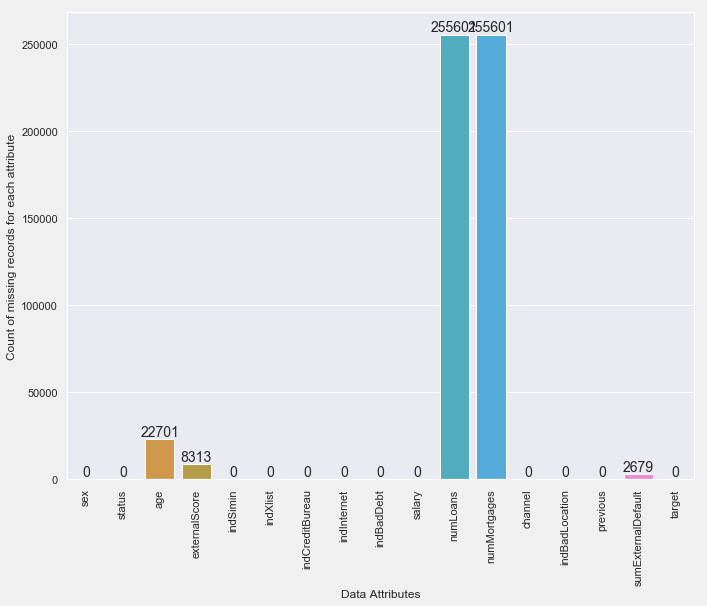

In [23]:
# Graphical representation of the missing values
x = training_data.columns
y = training_data.isnull().sum()


fig = plt.figure(figsize=(10,8))
style.use('fivethirtyeight')
sns.set()
sns.barplot(x,y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            int(height),
            fontsize=14, ha='center', va='bottom')
#sns.set(font_scale=1.5)
ax.set_xlabel("Data Attributes")
ax.set_ylabel("Count of missing records for each attribute")
plt.xticks(rotation=90)
plt.show()

In [29]:
# age
training_data.age.value_counts()
print(training_data.age.isnull().sum())

# Impute age by median value

training_data['age'] = training_data['age'].fillna(training_data['age'].median())

print(training_data.age.isnull().sum())
training_data.age.value_counts()

25.0     15729
21.0     15628
22.0     15378
26.0     15366
32.0     15107
31.0     15023
23.0     14717
33.0     14562
29.0     14471
27.0     14419
28.0     14412
30.0     14304
24.0     14287
34.0     14207
35.0     13961
36.0     13918
37.0     13903
38.0     13310
39.0     13188
40.0     12371
41.0     11738
42.0     11570
43.0     11019
44.0     10307
45.0     10077
46.0      9831
47.0      9469
48.0      9030
49.0      8399
50.0      7846
20.0      7714
51.0      7575
52.0      7050
53.0      6778
54.0      6467
55.0      5877
56.0      5252
57.0      5007
58.0      4785
59.0      4624
19.0      4104
60.0      4087
61.0      3841
62.0      3401
63.0      3162
64.0      3018
66.0      2707
65.0      2669
67.0      2446
68.0      2329
69.0      2098
70.0      1769
71.0      1655
72.0      1451
73.0      1323
74.0      1319
75.0      1162
76.0      1083
77.0       939
78.0       854
79.0       840
18.0       746
80.0       735
81.0       668
82.0       534
83.0       505
84.0      

22701
0


37.0     36604
25.0     15729
21.0     15628
22.0     15378
26.0     15366
32.0     15107
31.0     15023
23.0     14717
33.0     14562
29.0     14471
27.0     14419
28.0     14412
30.0     14304
24.0     14287
34.0     14207
35.0     13961
36.0     13918
38.0     13310
39.0     13188
40.0     12371
41.0     11738
42.0     11570
43.0     11019
44.0     10307
45.0     10077
46.0      9831
47.0      9469
48.0      9030
49.0      8399
50.0      7846
20.0      7714
51.0      7575
52.0      7050
53.0      6778
54.0      6467
55.0      5877
56.0      5252
57.0      5007
58.0      4785
59.0      4624
19.0      4104
60.0      4087
61.0      3841
62.0      3401
63.0      3162
64.0      3018
66.0      2707
65.0      2669
67.0      2446
68.0      2329
69.0      2098
70.0      1769
71.0      1655
72.0      1451
73.0      1323
74.0      1319
75.0      1162
76.0      1083
77.0       939
78.0       854
79.0       840
18.0       746
80.0       735
81.0       668
82.0       534
83.0       505
84.0      

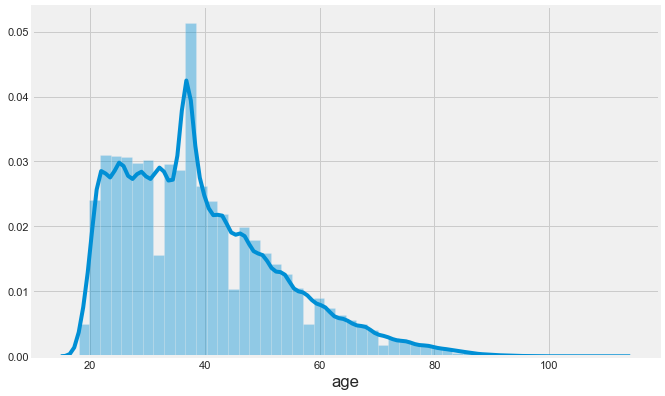

In [26]:
# Plot distribution of age to see if there are any outliers and the distribution of this variable 

fig = plt.figure(figsize=(10,6))
style.use('fivethirtyeight')
sns.distplot(training_data.age)

In [30]:
# externalScore

training_data.externalScore.value_counts()
print(training_data.externalScore.isnull().sum())


663.0    12471
644.0     3474
574.0     2233
855.0     1962
518.0     1532
808.0     1435
525.0     1384
608.0     1257
533.0     1226
601.0     1219
623.0     1190
805.0     1170
616.0     1162
684.0     1152
625.0     1151
699.0     1101
637.0     1076
594.0     1075
548.0     1070
658.0     1064
540.0     1062
630.0     1059
845.0     1030
722.0     1026
747.0     1020
678.0     1010
651.0      996
555.0      990
653.0      987
691.0      980
588.0      973
704.0      969
763.0      968
710.0      956
563.0      956
786.0      953
671.0      952
757.0      950
510.0      944
796.0      941
664.0      936
728.0      935
742.0      930
818.0      928
762.0      925
736.0      924
697.0      924
721.0      923
712.0      921
581.0      920
774.0      914
752.0      913
779.0      909
791.0      908
751.0      907
718.0      907
768.0      905
740.0      903
730.0      901
837.0      901
484.0      897
724.0      897
497.0      896
646.0      896
632.0      896
746.0      895
784.0     

8313


In [31]:
# Impute externalScore by median value

training_data['externalScore'] = training_data['externalScore'].fillna(training_data['externalScore'].median())

print(training_data.externalScore.isnull().sum())
training_data.externalScore.value_counts()


0


663.0    12471
649.0     9147
644.0     3474
574.0     2233
855.0     1962
518.0     1532
808.0     1435
525.0     1384
608.0     1257
533.0     1226
601.0     1219
623.0     1190
805.0     1170
616.0     1162
684.0     1152
625.0     1151
699.0     1101
637.0     1076
594.0     1075
548.0     1070
658.0     1064
540.0     1062
630.0     1059
845.0     1030
722.0     1026
747.0     1020
678.0     1010
651.0      996
555.0      990
653.0      987
691.0      980
588.0      973
704.0      969
763.0      968
710.0      956
563.0      956
786.0      953
671.0      952
757.0      950
510.0      944
796.0      941
664.0      936
728.0      935
742.0      930
818.0      928
762.0      925
697.0      924
736.0      924
721.0      923
712.0      921
581.0      920
774.0      914
752.0      913
779.0      909
791.0      908
718.0      907
751.0      907
768.0      905
740.0      903
730.0      901
837.0      901
484.0      897
724.0      897
497.0      896
632.0      896
646.0      896
746.0     

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


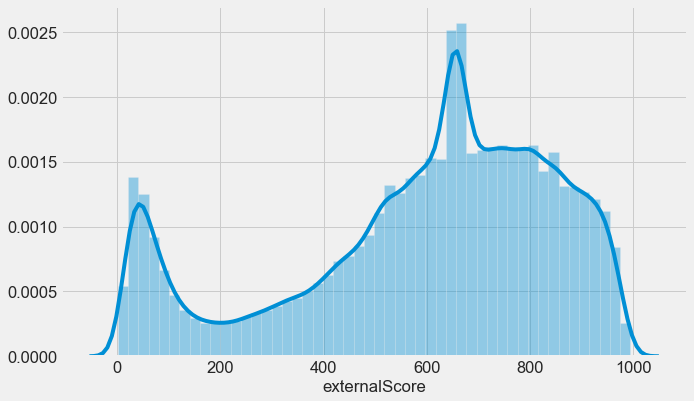

In [32]:
# Plot distribution of externalScore to see if there are any outliers and the distribution of this variable 
fig = plt.figure(figsize=(10,6))
style.use('fivethirtyeight')
sns.distplot(training_data.externalScore)

In [34]:
# numLoans
training_data.numLoans.value_counts()

training_data.numLoans.isnull().sum()

0.0     91649
1.0     90994
2.0     45921
3.0     23239
4.0     10313
5.0      3798
6.0      1117
7.0       245
8.0        52
9.0         9
14.0        1
Name: numLoans, dtype: int64

255601

In [32]:
# Too many nulls (over 50%) so dropping numLoans
training_data = training_data.drop('numLoans', axis=1)


In [35]:
# numMortgages
training_data.numMortgages.value_counts()
training_data.numMortgages.isnull().sum()

0.0    254600
1.0     12476
2.0       252
3.0        10
Name: numMortgages, dtype: int64

255601

In [36]:
# Too many nulls (over 50%) so dropping numMortgages
training_data = training_data.drop('numMortgages', axis=1)

In [43]:
# sumExternalDefault
training_data.sumExternalDefault.value_counts()
training_data.sumExternalDefault.isnull().sum()

0.000000e+00    368173
4.836326e+02      2679
4.262000e+02       300
2.000000e+01       296
5.000000e+00       241
6.540000e+00       170
1.000000e+01       170
8.960000e+00       159
4.960000e+00       147
3.682000e+02       137
4.214000e+02       128
6.980000e+00       111
1.295000e+01       109
4.900000e+00       108
2.499000e+01       106
2.500000e+01       101
4.000000e+01        96
1.500000e+01        95
9.920000e+00        91
7.000000e+00        90
6.550000e+00        84
6.780000e+00        77
2.300000e+01        77
3.002000e+01        77
1.949000e+01        68
8.410000e+00        64
1.595000e+01        61
1.000000e+02        60
1.400000e+01        60
3.000000e+01        59
1.098000e+01        58
6.940000e+00        57
2.400000e+01        55
2.478000e+01        55
8.390000e+00        55
1.500000e+02        54
9.990000e+00        53
3.500000e+01        53
8.400000e+00        53
2.096000e+01        52
3.634000e+02        52
3.600000e+01        52
2.425000e+01        51
6.000000e+0

0

In [39]:
# Impute sumExternalDefault by mean value

training_data['sumExternalDefault'] = training_data['sumExternalDefault'].fillna(training_data['sumExternalDefault'].mean())
training_data.sumExternalDefault.isnull().sum()

0

In [40]:
# Value Counts for sumExternalDefault
training_data.sumExternalDefault.value_counts()

0.000000e+00    368173
4.836326e+02      2679
4.262000e+02       300
2.000000e+01       296
5.000000e+00       241
6.540000e+00       170
1.000000e+01       170
8.960000e+00       159
4.960000e+00       147
3.682000e+02       137
4.214000e+02       128
6.980000e+00       111
1.295000e+01       109
4.900000e+00       108
2.499000e+01       106
2.500000e+01       101
4.000000e+01        96
1.500000e+01        95
9.920000e+00        91
7.000000e+00        90
6.550000e+00        84
6.780000e+00        77
2.300000e+01        77
3.002000e+01        77
1.949000e+01        68
8.410000e+00        64
1.595000e+01        61
1.000000e+02        60
1.400000e+01        60
3.000000e+01        59
1.098000e+01        58
6.940000e+00        57
2.400000e+01        55
2.478000e+01        55
8.390000e+00        55
1.500000e+02        54
9.990000e+00        53
3.500000e+01        53
8.400000e+00        53
2.096000e+01        52
3.634000e+02        52
3.600000e+01        52
2.425000e+01        51
6.000000e+0

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


sex                        0
status                     0
age                        0
externalScore              0
indSimin                   0
indXlist                   0
indCreditBureau            0
indInternet                0
indBadDebt                 0
salary                     0
numLoans              255601
channel                    0
indBadLocation             0
previous                   0
sumExternalDefault         0
target                     0
dtype: int64

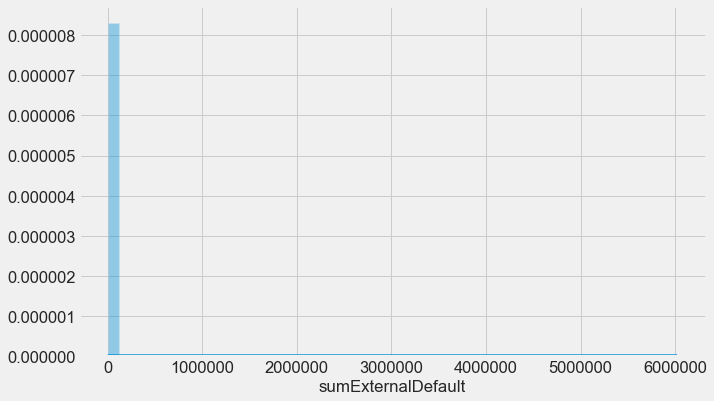

In [42]:
fig = plt.figure(figsize=(10,6))
style.use('fivethirtyeight')
sns.distplot(training_data.sumExternalDefault)
# Highly concentrated in zero value
training_data.isnull().sum()

### Correlation

In [43]:
# Get the correlation of the training dataset
training_data[training_data.columns[0:]].corr()

age  externalScore  indSimin  indXlist  \
age                 1.000000       0.327044  0.210036  0.034338   
externalScore       0.327044       1.000000  0.105529 -0.048830   
indSimin            0.210036       0.105529  1.000000 -0.078886   
indXlist            0.034338      -0.048830 -0.078886  1.000000   
indCreditBureau     0.027433      -0.217487 -0.005982  0.024611   
indInternet        -0.060217       0.018787  0.137329 -0.442318   
indBadDebt         -0.042914      -0.492448 -0.023332  0.023786   
indBadLocation      0.010870      -0.040080  0.011073  0.018933   
sumExternalDefault  0.008608      -0.068214 -0.001196  0.004241   
target             -0.088161      -0.221554 -0.081625  0.062213   

                    indCreditBureau  indInternet  indBadDebt  indBadLocation  \
age                        0.027433    -0.060217   -0.042914        0.010870   
externalScore             -0.217487     0.018787   -0.492448       -0.040080   
indSimin                  -0.005982     0.137329   -0.023332        0.011073   
indXlist                   0.024611    -0.442318    0.023786        0.018933   
indCreditBureau            1.000000    -0.011831    0.169119       -0.013597   
indInternet               -0.011831     1.000000   -0.002633       -0.004749   
indBadDebt                 0.169119    -0.002633    1.000000        0.055464   
indBadLocation            -0.013597    -0.004749    0.055464        1.000000   
sumExternalDefault         0.063064    -0.003922    0.069329        0.002455   
target                     0.046824    -0.064515    0.148744        0.081940   

                    sumExternalDefault    target  
age                           0.008608 -0.088161  
externalScore                -0.068214 -0.221554  
indSimin                     -0.001196 -0.081625  
indXlist                      0.004241  0.062213  
indCreditBureau               0.063064  0.046824  
indInternet                  -0.003922 -0.064515  
indBadDebt                    0.069329  0.148744  
indBadLocation                0.002455  0.081940  
sumExternalDefault            1.000000  0.009636  
target                        0.009636  1.000000

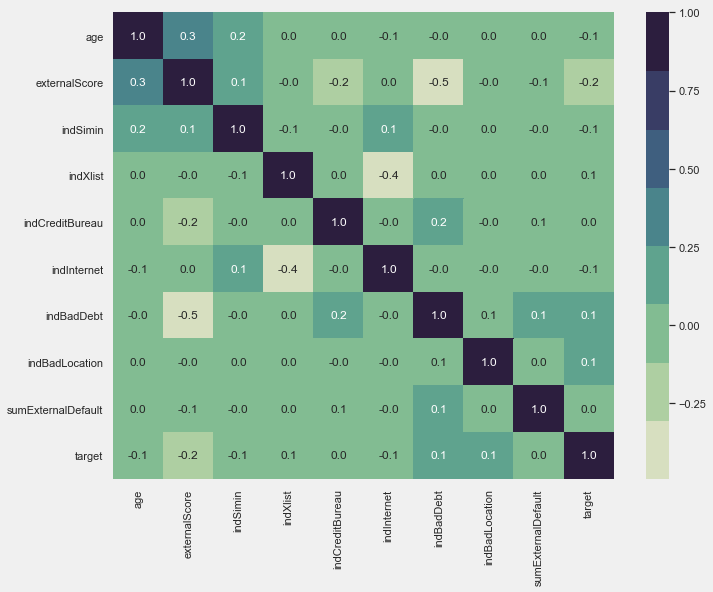

In [44]:
# Visual representation of correlation
fig = plt.figure(figsize=(10,8))
style.use('fivethirtyeight')
sns.set()
sns.heatmap(training_data[training_data.columns[1:]].corr(),annot=True,fmt=".1f",
            cmap=(sns.cubehelix_palette(8, start=.5, rot=-.75)))
plt.show()

No variables seem to be highly correlated with each other, therefore no further action will be taken here.

### Creating Dummies


In [45]:
training_data.head()

sex   status   age  externalScore  indSimin  indXlist  indCreditBureau  \
0  Female   Single  23.0          373.0         0         0                0   
1    Male   Single  27.0          702.0         1         0                0   
2    Male   Single  28.0          728.0         0         0                0   
3    Male   Single  45.0          650.0         0         0                0   
4  Female  Unknown  37.0          625.0         0         0                0   

   indInternet  indBadDebt       salary  numLoans         channel  \
0            1           1  [1000,1300)       NaN  External Agent   
1            1           0  [1500,2000)       1.0  External Agent   
2            1           0  [1500,2000)       2.0  External Agent   
3            0           0  [1000,1300)       1.0     Call Center   
4            1           0   [650,1000)       NaN  External Agent   

   indBadLocation       previous  sumExternalDefault  target  
0               0         Normal             1173.46       1  
1               0  Restructuring                0.00       0  
2               0  Restructuring                0.00       1  
3               0         Unpaid                0.00       1  
4               0         Normal                0.00       0

In [56]:
# creating Dummies
dummy_cols = ['sex', 'status', 'channel','previous', 'salary'
             ]
training_data_dummies = pd.get_dummies(training_data, columns = dummy_cols).dropna()
training_data_dummies.head()
training_data_dummies.shape

age  externalScore  indSimin  indXlist  indCreditBureau  indInternet  \
1  27.0          702.0         1         0                0            1   
2  28.0          728.0         0         0                0            1   
3  45.0          650.0         0         0                0            0   
7  58.0          804.0         0         0                0            0   
9  51.0          826.0         0         0                0            1   

   indBadDebt  numLoans  indBadLocation  sumExternalDefault  target  \
1           0       1.0               0                 0.0       0   
2           0       2.0               0                 0.0       1   
3           0       1.0               0                 0.0       1   
7           0       2.0               0                 0.0       0   
9           0       1.0               0                 0.0       0   

   sex_Female  sex_Male  status_Divorced  status_Married  status_Single  \
1           0         1                0               0              1   
2           0         1                0               0              1   
3           0         1                0               0              1   
7           0         1                0               1              0   
9           0         1                0               1              0   

   status_Unknown  status_Widower  channel_App  channel_Branch  \
1               0               0            0               0   
2               0               0            0               0   
3               0               0            0               0   
7               0               0            0               1   
9               0               0            0               0   

   channel_Call Center  channel_External Agent  channel_Online  \
1                    0                       1               0   
2                    0                       1               0   
3                    1                       0               0   
7                    0                       0               0   
9                    0                       0               0   

   channel_Recovery  channel_Unknown  previous_Default  previous_Normal  \
1                 0                0                 0                0   
2                 0                0                 0                0   
3                 0                0                 0                0   
7                 0                0                 0                0   
9                 1                0                 0                0   

   previous_Refinancing  previous_Restructuring  previous_Unpaid  salary_<650  \
1                     0                       1                0            0   
2                     0                       1                0            0   
3                     0                       0                1            0   
7                     0                       0                1            0   
9                     0                       1                0            0   

   salary_>8000  salary_None  salary_Unknown  salary_[1000,1300)  \
1             0            0               0                   0   
2             0            0               0                   0   
3             0            0               0                   1   
7             0            0               0                   0   
9             0            0               0                   0   

   salary_[1300,1500)  salary_[1500,2000)  salary_[2000,3000)  \
1                   0                   1                   0   
2                   0                   1                   0   
3                   0                   0                   0   
7                   0                   0                   1   
9                   0                   1                   0   

   salary_[3000,5000)  salary_[5000,8000)  salary_[650,1000)  
1                   0                   0                  0  
2          

(267338, 41)

### Train and build baseline model


In [57]:
X = training_data_dummies.drop('target', axis=1)
Y = training_data_dummies.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


#### KNN

In [59]:
knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
                             metric='minkowski', metric_params=None)
knMod.fit(X_train, Y_train)
knMod.score(X_test, Y_test)
test_labels=knMod.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(Y_test,test_labels , average='macro', sample_weight=None)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

0.6678536694845515

0.6261153621993083

#### Logistic Regression

In [60]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, 
                            random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)

In [61]:
glmMod.fit(X_train, Y_train)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

In [62]:
glmMod.score(X_test, Y_test)

0.7203561008453655

In [63]:
test_labels=glmMod.predict_proba(np.array(X_test.values))[:,1]


In [64]:
roc_auc_score(Y_test,test_labels , average='macro', sample_weight=None)


0.7270854358123056

#### Ada Boost

In [65]:
adaMod = AdaBoostClassifier(base_estimator=None, n_estimators=200, learning_rate=1.0)


In [66]:
adaMod.fit(X_train, Y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=None)

In [67]:
adaMod.score(X_test, Y_test)


0.7212388718485824

In [68]:
test_labels=adaMod.predict_proba(np.array(X_test.values))[:,1]


In [69]:
roc_auc_score(Y_test,test_labels , average='macro', sample_weight=None)


0.7283249316026816

#### Gradient Boosting

In [67]:
gbMod = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0)

In [68]:
gbMod.fit(X_train, Y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
gbMod.score(X_test, Y_test)


0.698856465368876

In [70]:
test_labels=gbMod.predict_proba(np.array(X_test.values))[:,1]


In [71]:
roc_auc_score(Y_test,test_labels , average='macro', sample_weight=None)


0.7097711745259047

#### Random Forest

In [72]:
rfMod = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
                               random_state=None, verbose=0)

In [73]:
rfMod.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [74]:
rfMod.score(X_test, Y_test)


0.6516770566412973

In [75]:
test_labels=rfMod.predict_proba(np.array(X_test.values))[:,1]


In [76]:
roc_auc_score(Y_test,test_labels , average='macro', sample_weight=None)


0.6362953876690449

### Cross Validation

In [77]:
from sklearn.model_selection import cross_val_score
def cvDictGen(functions, scr, X_train=X, Y_train=Y, cv=5, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, Y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

def cvDictNormalize(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[cvDict.keys()[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[cvDict.keys()[0]][1]))]
    return cvDictNormalized

In [78]:
cvD = cvDictGen(functions=[knMod, glmMod, adaMod, gbMod, rfMod], scr='roc_auc')
cvD

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 27.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

### Hyper parameter optimization using Randomized search


Two highest scores came with Ada Boost and Gradient Boost, now we optimize the parameters for these models in order to pick the highest one 

#### ADA Boost Hyperparameter optimization

In [74]:
adaHyperParams = {'n_estimators': [10,50,100,200,420]}

In [75]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=adaHyperParams, n_iter=5,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, Y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.8s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   1.7s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.7s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   7.9s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   7.4s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   7.1s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  14.0s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=  13.9s
[CV] n_estimators=100 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.6min finished


In [76]:
gridSearchAda.best_params_, gridSearchAda.best_score_

##### 'n_estimators': 420}, 0.7055228847405199 #####

({'n_estimators': 420}, 0.7054750423788134)

#### Gradient Boost Hyperparameter optimization

In [77]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

# originally n_estimators: 10,500
# originally max_depth: 1:10 

In [78]:
gridSearchGB  = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] loss=deviance, max_depth=4, n_estimators=111 ....................
[CV] ..... loss=deviance, max_depth=4, n_estimators=111, total=  49.9s
[CV] loss=deviance, max_depth=4, n_estimators=111 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.6s remaining:    0.0s


[CV] ..... loss=deviance, max_depth=4, n_estimators=111, total=  53.2s
[CV] loss=deviance, max_depth=4, n_estimators=111 ....................
[CV] ..... loss=deviance, max_depth=4, n_estimators=111, total=  49.6s
[CV] loss=deviance, max_depth=8, n_estimators=87 .....................
[CV] ...... loss=deviance, max_depth=8, n_estimators=87, total= 3.1min
[CV] loss=deviance, max_depth=8, n_estimators=87 .....................
[CV] ...... loss=deviance, max_depth=8, n_estimators=87, total= 3.2min
[CV] loss=deviance, max_depth=8, n_estimators=87 .....................
[CV] ...... loss=deviance, max_depth=8, n_estimators=87, total= 3.0min
[CV] loss=exponential, max_depth=3, n_estimators=389 .................
[CV] .. loss=exponential, max_depth=3, n_estimators=389, total= 1.8min
[CV] loss=exponential, max_depth=3, n_estimators=389 .................
[CV] .. loss=exponential, max_depth=3, n_estimators=389, total= 1.9min
[CV] loss=exponential, max_depth=3, n_estimators=389 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 822.5min finished


In [79]:
gridSearchGB.best_params_, gridSearchGB.best_score_

#### {'loss': 'exponential', 'max_depth': 8, 'n_estimators': 59}, 0.7135200871575476 ####

({'loss': 'deviance', 'max_depth': 6, 'n_estimators': 156}, 0.7134517259944717)

### Training with optimized parameters 


In [80]:
# Ada Boost after Grid Search
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, Y_train)

In [81]:
# Gradient Boost after Grid Search
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, Y_train)


In [82]:
#cvDictbestpara = cvDictGen(functions=[bestGbModFitted, bestAdaModFitted], scr='roc_auc')


In [83]:
#cvDictbestpara


In [84]:
# Ada Boost roc_auc_score
test_labels=bestAdaModFitted.predict_proba(np.array(X_test.values))[:,1]

In [85]:
roc_auc_score(Y_test,test_labels , average='macro', sample_weight=None)

0.7054258436327255

In [86]:
# Gradient Boost roc_auc_score
test_labels=bestGbModFitted.predict_proba(np.array(X_test.values))[:,1]


In [87]:
roc_auc_score(Y_test,test_labels , average='macro', sample_weight=None)


0.7139619574490358

### Working on test set

Clean test set and make dummies to be able to run the model 


In [88]:
test_data_dummies = test_data.drop('customerID', axis=1)


In [89]:
test_data_dummies['age'] = test_data_dummies['age'].fillna(test_data_dummies['age'].median())


In [90]:
test_data_dummies['externalScore'] = test_data_dummies['externalScore'].fillna(test_data_dummies['externalScore'].median())


In [91]:
test_data_dummies = test_data_dummies.drop('numLoans', axis=1)


In [92]:
test_data_dummies = test_data_dummies.drop('numMortgages', axis=1)


In [93]:
test_data_dummies['sumExternalDefault'] = test_data_dummies['sumExternalDefault'].fillna(test_data_dummies['sumExternalDefault'].mean())


In [94]:
dummy_cols = ['sex', 'status', 'channel','previous', 'salary'
             ]
test_data_dummies = pd.get_dummies(test_data_dummies, columns = dummy_cols)

In [95]:
test_data_dummies.describe()


age  externalScore       indSimin       indXlist  \
count  174313.000000  174313.000000  174313.000000  174313.000000   
mean       38.978493     592.274954       0.098111       0.053719   
std        13.620117     259.541010       0.297465       0.225464   
min        18.000000       1.000000       0.000000       0.000000   
25%        28.000000     463.000000       0.000000       0.000000   
50%        37.000000     648.000000       0.000000       0.000000   
75%        47.000000     788.000000       0.000000       0.000000   
max       108.000000     995.000000       1.000000       1.000000   

       indCreditBureau    indInternet     indBadDebt  indBadLocation  \
count    174313.000000  174313.000000  174313.000000   174313.000000   
mean          0.042160       0.773614       0.290546        0.171444   
std           0.200954       0.418493       0.454016        0.376898   
min           0.000000       0.000000       0.000000        0.000000   
25%           0.000000       1.000000       0.000000        0.000000   
50%           0.000000       1.000000       0.000000        0.000000   
75%           0.000000       1.000000       1.000000        0.000000   
max           1.000000       1.000000       1.000000        1.000000   

       sumExternalDefault     sex_Female        ...           salary_>8000  \
count       174313.000000  174313.000000        ...          174313.000000   
mean           465.633592       0.628043        ...               0.005852   
std           4966.963367       0.483328        ...               0.076271   
min              0.000000       0.000000        ...               0.000000   
25%              0.000000       0.000000        ...               0.000000   
50%              0.000000       1.000000        ...               0.000000   
75%             38.160000       1.000000        ...               0.000000   
max         999586.200000       1.000000        ...               1.000000   

         salary_None  salary_Unknown  salary_[1000,1300)  salary_[1300,1500)  \
count  174313.000000   174313.000000       174313.000000       174313.000000   
mean        0.006844        0.004538            0.502349            0.107714   
std         0.082445        0.067210            0.499996            0.310020   
min         0.000000        0.000000            0.000000            0.000000   
25%         0.000000        0.000000            0.000000            0.000000   
50%         0.000000        0.000000            1.000000            0.000000   
75%         0.000000        0.000000            1.000000            0.000000   
max         1.000000        1.000000            1.000000            1.000000   

       salary_[1500,2000)  salary_[2000,3000)  salary_[3000,5000)  \
count       174313.000000       174313.000000       174313.000000   
mean             0.113118            0.072840            0.032447   
std              0.316738            0.259875            0.177186   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max              1.000000            1.000000            1.000000   

       salary_[5000,8000)  salary_[650,1000)  
count       174313.000000      174313.000000  
mean             0.013722           0.102689  
std              0.116337           0.303553  
min              0.000000           0.000000  
25%              0.000000           0.000000  
50%              0.000000           0.000000  
75%              0.000000           0.000000  
max              1.000000           1.000000  

[8 rows x 39 columns]

#### Using model on test set

In [96]:
# Here, we choose the best model --> GRADIENT BOOST
model = gridSearchGB.best_estimator_

In [97]:
predictions = model.predict_proba(test_data_dummies)
predictions


array([[0.78439976, 0.21560024],
       [0.38661871, 0.61338129],
       [0.8610644 , 0.1389356 ],
       ...,
       [0.90328232, 0.09671768],
       [0.52978722, 0.47021278],
       [0.74125129, 0.25874871]])

In [98]:
predictions = pd.DataFrame(predictions, columns=['Prediction 0', 'prediction'])


In [5]:
# We get the probability that someone doesn't default (0) and the probability that someone does (1) 
predictions

NameError: name 'predictions' is not defined

In [100]:
# We drop the probability of 0 and keep the probability of 1 (aka. someone defaulting, which is what we're looking for)
predictions = predictions.drop('Prediction 0', axis=1)

In [101]:
# We concatenate the original test dataset with the prediction of someone defaulting 
submission = pd.concat([test_data, predictions], axis=1)

In [102]:
submission.head(20)

customerID     sex   status   age  externalScore  indSimin  indXlist  \
0   D_00044539972  Female   Single  26.0          510.0         0         0   
1   D_00074041049  Female   Single  20.0          739.0         0         0   
2   D_00041998439    Male   Single  63.0          893.0         0         0   
3   D_00041534199    Male   Single  32.0          734.0         0         0   
4   D_00046605056    Male   Single  23.0          485.0         0         0   
5   D_00008122018  Female   Single  54.0          687.0         0         0   
6   D_00043147232    Male   Single  28.0          681.0         0         0   
7   D_00027250394  Female   Single  59.0          932.0         0         0   
8   D_00987656775    Male  Widower   NaN            NaN         0         0   
9   D_00029645583    Male   Single  38.0          799.0         0         0   
10  D_00010195386    Male   Single  39.0          700.0         0         0   
11  R_10405300881  Female   Single  33.0          731.0         0         0   
12  D_00032139010    Male   Single  40.0          699.0         0         0   
13  D_00041413097  Female   Single  33.0          151.0         1         0   
14  D_00041443036    Male  Married  32.0          364.0         0         0   
15  D_00010251965  Female   Single  38.0          845.0         0         0   
16  D_00041726034  Female   Single  30.0           54.0         0         0   
17  D_00026631485  Female   Single  50.0          845.0         0         0   
18  D_00025706073  Female   Single  42.0          615.0         0         0   
19  D_00032799887    Male  Married  48.0          882.0         0         0   

    indCreditBureau  indInternet  indBadDebt       salary  numLoans  \
0                 0            1           0  [1300,1500)       NaN   
1                 0            1           0         <650       NaN   
2                 0            0           0  [1300,1500)       1.0   
3                 0            0           0  [1000,1300)       0.0   
4                 0            1           1  [1300,1500)       1.0   
5                 0            0           1  [1300,1500)       NaN   
6                 0            1           0  [1000,1300)       2.0   
7                 0            1           0  [1000,1300)       NaN   
8                 0            1           0      Unknown       NaN   
9                 0            1           0  [1500,2000)       3.0   
10                0            1           0  [1000,1300)       2.0   
11                0            1           0  [1000,1300)       NaN   
12                0            1           1  [1000,1300)       2.0   
13                0            1           1  [3000,5000)       5.0   
14                0            1           0  [1300,1500)       1.0   
15                0            0           0  [1000,1300)       NaN   
16                0            0           0  [1000,1300)       0.0   
17                0            1           0  [1000,1300)       NaN   
18                0            1           0  [1000,1300)       NaN   
19                0            1           0  [3000,5000)       5.0   

    numMortgages         channel  indBadLocation       previous  \
0            NaN     Call Center               0         Normal   
1            NaN  External Agent               0         Normal   
2            0.0          Branch               0        Default   
3            0.0     Call Center               1    Refinancing   
4            0.0  External Agent               0  Restructuring   
5            NaN          Branch               0         Unpaid   
6            0.0             App               0         Normal   
7            NaN  External Agent               0  Restructuring   
8            NaN  External Agent               0         Normal   
9            0.0        Recovery               0  Restructuring   
10           0.0     Call Center               0         Normal   
11           NaN             App               0   

In [103]:
submission.shape

(174313, 18)

In [104]:
submission.to_csv('submission.csv', index = False)